# Safety zone modeling example
- using prioritized region method, make safety zone

## import model

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import os
import re
import cv2

## prepare 3D motion model

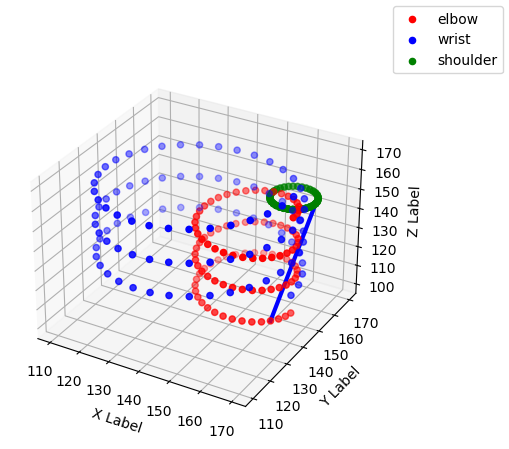

In [3]:
time = [0.1 * i for i in range(100)]
theta = np.linspace(0, 6 * np.pi, 100)  # Create 100 points evenly spaced from 0 to 2*pi
X_wrist = 30 * np.cos(theta) + 140
Y_wrist = 30 * np.sin(theta) + 140
Z_wrist = [0.5 * i + 120 for i in range(100)]

X_elbow = [15 * np.cos(-theta[i]) + 150 for i in range(len(theta))]
Y_elbow = [15 * np.sin(-theta[i]) + 150 for i in range(len(theta))]
Z_elbow = [0.5 * i + 100 for i in range(100)]

X_shoulder = [7 * np.cos(theta[i]) + 160 for i in range(len(theta))]
Y_shoulder = [7 * np.sin(theta[i]) + 160 for i in range(len(theta))]
Z_shoulder = [150 for i in range(100)]

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")


# Scatter plot the points
ax.scatter(X_elbow, Y_elbow, Z_elbow, c="r", marker="o", label="elbow")
ax.scatter(X_wrist, Y_wrist, Z_wrist, c="b", marker="o", label="wrist")
ax.scatter(X_shoulder, Y_shoulder, Z_shoulder, c="g", marker="o", label="shoulder")

ax.plot(
    [X_shoulder[3], X_elbow[3]],
    [Y_shoulder[3], Y_elbow[3]],
    [Z_shoulder[3], Z_elbow[3]],
    linestyle="-",
    linewidth=3,
    color="blue",
)

# Set labels for each axis
ax.set_xlabel("X Label")
ax.set_ylabel("Y Label")
ax.set_zlabel("Z Label")
fig.legend()
# Show the plot
plt.show()

## prioritized region method

In [4]:
a = np.array([1, 2, 3])
a_norm = np.linalg.norm(a)
print(a_norm)

3.7416573867739413


### safety zone setting

In [5]:
def safetyZone(position, accerelation, velocity, time=0.1, radius=30, numData=5):
    """safety zone setting

    Args:
        position(np.array) : current position
        accerelation (float): acceleration norm
        velocity (np.array): (vx,vy,vz)
        time (float, optional): moving time of joint. Defaults to 0.1.
        radius (float) : joints' safety zone radius
    """
    # accerelation_norm = np.linalg.norm(accerelation)
    velocity_norm = np.linalg.norm(velocity)
    danger_distance = round(
        ((accerelation * time + velocity_norm) ** 2 - velocity_norm**2)
        / (2 * accerelation),
        2,
    )
    print(danger_distance)
    delta_pos = round(danger_distance / numData, 2)
    danger_zone = [
        [
            round(position[i + 1] + velocity[i] / velocity_norm * delta_pos * j, 2)
            for i in range(3)
        ]
        for j in range(numData + 1)
    ]
    return danger_zone

### make animation

### draw sphere

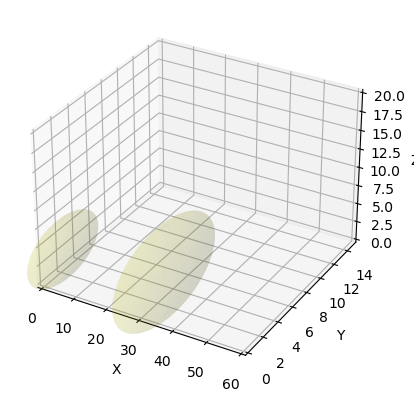

In [6]:
def plot_sphere(center, radius, fig, ax):
    # Create a set of theta and phi values to generate points on the sphere
    phi, theta = np.mgrid[0.0 : 2.0 * np.pi : 100j, 0.0 : np.pi : 50j]

    # Parametric equations for a sphere
    x = center[0] + radius * np.sin(theta) * np.cos(phi)
    y = center[1] + radius * np.sin(theta) * np.sin(phi)
    z = center[2] + radius * np.cos(theta)

    ax.plot_surface(x, y, z, color="y", alpha=0.1)

    # Plot the center of the sphere
    # ax.scatter(
    #    center[0], center[1], center[2], color="b", marker="o", s=100, label="Center"
    # )


fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
# Example usage
center = [1, 2, 3]
radius = 4
plot_sphere(center, radius, fig=fig, ax=ax)
center = [30, 3, 3]
radius = 6
plot_sphere(center, radius, fig=fig, ax=ax)
# Set labels
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_xlim(0, 60)
ax.set_ylim(0, 15)
ax.set_zlim(0, 20)
# Show plot
plt.show()

In [7]:
data_wrist = np.array(
    [[time[i], X_wrist[i], Y_wrist[i], Z_wrist[i]] for i in range(100)]
)
data_elbow = np.array(
    [[time[i], X_elbow[i], Y_elbow[i], Z_elbow[i]] for i in range(100)]
)
data_shoulder = np.array(
    [[time[i], X_shoulder[i], Y_shoulder[i], Z_shoulder[i]] for i in range(100)]
)
# print(data)

In [8]:
# prepare accerelation writst
a_w = 22.2  # wrist max accerelation
a_e = 14  # elbow max acceleration
a_s = 5  # shoulder max acceleration
radius_joint = 20
delta_time = 0.3  # processing time of joint Tracking :: around 0.01 sec ~ 100Hz
numSplitData = 7


def makeAnimation(data_wrist, data_elbow, data_shoulder, saveDir):
    # prepare saveDir
    if not os.path.exists(saveDir):
        os.makedirs(saveDir)

    for i in range(data_wrist.shape[0]):
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection="3d")
        # Scatter plot the points
        # plot trajectory
        ax.scatter(
            X_wrist[: (i + 1)],
            Y_wrist[: (i + 1)],
            Z_wrist[: (i + 1)],
            c="b",
            marker="o",
            label="wrist",
        )
        ax.scatter(
            X_elbow[: (i + 1)],
            Y_elbow[: (i + 1)],
            Z_elbow[: (i + 1)],
            c="r",
            marker="o",
            label="elbow",
        )
        ax.scatter(
            X_shoulder[: (i + 1)],
            Y_shoulder[: (i + 1)],
            Z_shoulder[: (i + 1)],
            c="g",
            marker="o",
            label="shoulder",
        )
        if i >= 1:
            velocity_wrist = [
                (data_wrist[i][j + 1] - data_wrist[i - 1][j + 1])
                / (data_wrist[i][0] - data_wrist[i - 1][0])
                for j in range(3)
            ]
            velocity_elbow = [
                (data_elbow[i][j + 1] - data_elbow[i - 1][j + 1])
                / (data_elbow[i][0] - data_elbow[i - 1][0])
                for j in range(3)
            ]
            velocity_shoulder = [
                (data_shoulder[i][j + 1] - data_shoulder[i - 1][j + 1])
                / (data_shoulder[i][0] - data_shoulder[i - 1][0])
                for j in range(3)
            ]
            danger_zone_wrist = safetyZone(
                position=data_wrist[i],
                accerelation=a_w,
                velocity=velocity_wrist,
                time=delta_time,
                radius=radius_joint,
                numData=numSplitData,
            )
            danger_zone_elbow = safetyZone(
                position=data_elbow[i],
                accerelation=a_e,
                velocity=velocity_elbow,
                time=delta_time,
                radius=radius_joint,
                numData=numSplitData,
            )
            danger_zone_shoulder = safetyZone(
                position=data_shoulder[i],
                accerelation=a_s,
                velocity=velocity_shoulder,
                time=delta_time,
                radius=radius_joint,
                numData=numSplitData,
            )
            print(danger_zone_wrist)
            print(danger_zone_elbow)
            print(danger_zone_shoulder)
            # plot danger zone with column
            # plot danger zone
            for j in range(len(danger_zone_wrist)):
                plot_sphere(
                    center=danger_zone_wrist[j], radius=radius_joint, fig=fig, ax=ax
                )
                plot_sphere(
                    center=danger_zone_elbow[j], radius=radius_joint, fig=fig, ax=ax
                )
                plot_sphere(
                    center=danger_zone_shoulder[j], radius=radius_joint, fig=fig, ax=ax
                )
        # Set labels
        ax.plot(
            [X_shoulder[i], X_elbow[i]],
            [Y_shoulder[i], Y_elbow[i]],
            [Z_shoulder[i], Z_elbow[i]],
            linestyle="-",
            linewidth=3,
            color="k",
        )
        ax.plot(
            [X_wrist[i], X_elbow[i]],
            [Y_wrist[i], Y_elbow[i]],
            [Z_wrist[i], Z_elbow[i]],
            linestyle="-",
            linewidth=3,
            color="k",
        )
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")
        ax.set_title(f"{(i+1):3d} frame")
        ax.set_xlim(0, 300)
        ax.set_ylim(0, 300)
        ax.set_zlim(0, 200)
        savePath = os.path.join(saveDir, f"{(i+1):3d}.jpg")
        fig.legend()
        fig.savefig(savePath)

In [ ]:
SAVE = r"C:\Users\kawaw\python\safetyZone"
makeAnimation(
    data_wrist=data_wrist,
    data_elbow=data_elbow,
    data_shoulder=data_shoulder,
    saveDir=SAVE,
)

## make video

In [10]:
def images_to_video(image_folder, video_name, fps=5):
    images = [img for img in os.listdir(image_folder) if img.endswith(".jpg")]
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape

    video = cv2.VideoWriter(
        video_name, cv2.VideoWriter_fourcc(*"mp4v"), fps, (width, height)
    )

    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))

    cv2.destroyAllWindows()
    video.release()


# Example usage
image_folder = r"C:\Users\kawaw\python\safetyZone"
video_name = r"C:\Users\kawaw\python\safety_zone.mp4"
images_to_video(image_folder=image_folder, video_name=video_name)